In [20]:
# Install libraries
!pip install yfinance prophet pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
# Data processing
import pandas as pd
import numpy as np

# Get time series data
import yfinance as yf

# Prophet model for time series forecast
from prophet import Prophet

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Multi-processing
from multiprocessing import Pool, cpu_count

# Spark
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType

# Process bar
from tqdm import tqdm

# Tracking time
from time import time

pandas and numpy are for data processing.

yfinance is for pulling stock price data from Yahoo Finance.

prophet is for building the time series model.

seaborn and matplotlib are for visualization.

Pool and cpu_count are for multi-processing.

pyspark.sql.types, pandas_udf, and PandasUDFType are for Spark parallel processing.

tqdm is for generating a process bar to show the completed percentage.

time is for tracking the time used for modeling and prediction.

In [22]:
# Data start date
start_date = '2020-01-02'

# Data end date
end_date = '2022-01-01'
# yfinance excludes the end date, so we need to add one day to the last day of data

In [23]:
# Download data
ticker_list = ['TSLA', 'GOOG', 'ORCL', 'MSFT', 'AMZN']

data = yf.download(ticker_list, start=start_date, end=end_date)[['Close']]

# Drop the top level column name
data.columns = data.columns.droplevel()

# Take a look at the data
data.head()

[*********************100%***********************]  5 of 5 completed


,AMZN,GOOG,MSFT,ORCL,TSLA
Date,,,,,
2020-01-02,94.900497,68.368500,160.619995,53.950001,28.684000
2020-01-03,93.748497,68.032997,158.619995,53.759998,29.534000
2020-01-06,95.143997,69.710503,159.029999,54.040001,30.102667
2020-01-07,95.343002,69.667000,157.580002,54.160000,31.270666
2020-01-08,94.598503,70.216003,160.089996,54.130001,32.809334


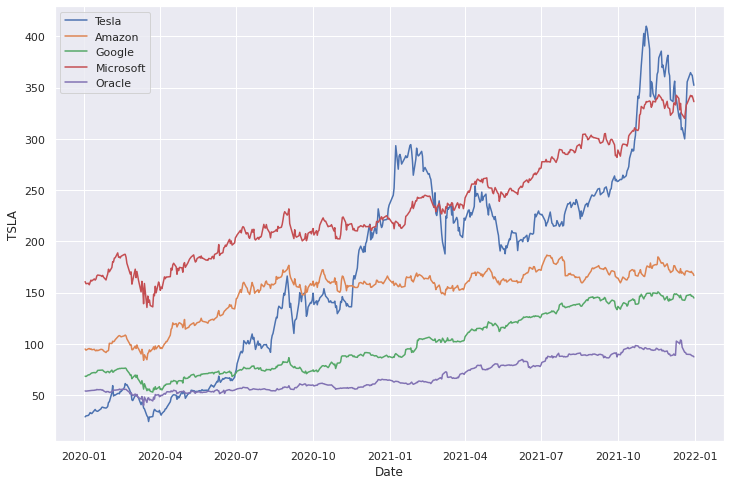

In [24]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data.index, y=data['TSLA'])
sns.lineplot(x=data.index, y=data['AMZN'])
sns.lineplot(x=data.index, y=data['GOOG'])
sns.lineplot(x=data.index, y=data['MSFT'])
sns.lineplot(x=data.index, y=data['ORCL'])
plt.legend(labels = ['Tesla', 'Amazon', 'Google', 'Microsoft', 'Oracle'])

In [25]:
# Data information
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 505 entries, 2020-01-02 to 2021-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMZN    505 non-null    float64
 1   GOOG    505 non-null    float64
 2   MSFT    505 non-null    float64
 3   ORCL    505 non-null    float64
 4   TSLA    505 non-null    float64
dtypes: float64(5)
memory usage: 23.7 KB


Next step is data processing 

the dataset is transformed from the wide format to the long format using the pandas .melt function.

Prophet requires at least two columns as inputs: a **ds** column and a y column.

The ds column has the time information. The column Date is renamed to ds.

The y column has the time series values. In this example, because we are predicting the closing stock price, y represents the stock close price.

There is no pre-defined name for the individual time series in prophet, so we can keep the name ticker as is.

In [26]:
# Release Date from the index
data = data.reset_index()

# Change data from the wide format to the long format
df = pd.melt(data, id_vars='Date', value_vars=['AMZN', 'TSLA', 'GOOG', 'MSFT', 'ORCL'])

df.columns = ['ds', 'ticker', 'y']
df.tail(10)
#df.ticker.value_counts()

,ds,ticker,y
2515,2021-12-17,ORCL,96.620003
2516,2021-12-20,ORCL,91.639999
2517,2021-12-21,ORCL,91.510002
2518,2021-12-22,ORCL,89.860001
2519,2021-12-23,ORCL,89.720001
2520,2021-12-27,ORCL,89.540001
2521,2021-12-28,ORCL,88.650002
2522,2021-12-29,ORCL,88.209999
2523,2021-12-30,ORCL,88.010002
2524,2021-12-31,ORCL,87.209999


In [27]:
# Check the dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2525 entries, 0 to 2524
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2525 non-null   datetime64[ns]
 1   ticker  2525 non-null   object        
 2   y       2525 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 59.3+ KB


Next, we group the pandas dataframe by the column ticker and save it in a new dataframe called groups_by_ticker. 

Using .groups.keys(), we can confirm that there are five groups, one group for each ticker.

In [28]:
# Group the data by ticker
groups_by_ticker = df.groupby('ticker')
# Check the groups in the dataframe
groups_by_ticker.groups.keys()

dict_keys(['AMZN', 'GOOG', 'MSFT', 'ORCL', 'TSLA'])

the function for training and forecasting each group is defined.

The input data is an individual time series data for a group.

Prophet() initiates the time series model with the default hyperparameters, and we give the model the name m.

m.fit(group) fits the prophet model on the individual time series data, which is the stock price data for a ticker.

make_future_dataframe creates a new dataframe called future for the forecasting. periods=15 means that we will forecast for 15 days of data. To use a different frequency, we can specify the freq option. For example, periods=15, freq='MS' means that we are forecasting for the next 15 months.


After predicting on the future dataframe, prophet produces a long list of outputs. 

We only kept ds, yhat, yhat_lower and yhat_upper. yhat is the predicted value. yhat_lower and yhat_upper are the lower and upper bound of the uncertainty interval.

A new column called ticker is created in the forecast dataframe to indicate the ticker name for the predictions.


The output of the function has 5 columns: ds, ticker, yhat, yhat_upper, and yhat_lower.

In [29]:
def train_and_forecast(group):
  # Initiate the model
  m = Prophet()
  
  # Fit the model
  m.fit(group)
  
  # Make predictions
  future = m.make_future_dataframe(periods=15)
  forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  forecast['ticker'] = group['ticker'].iloc[0]
  
  # Return the forecasted results
  return forecast[['ds', 'ticker', 'yhat', 'yhat_upper', 'yhat_lower']] 

In [30]:
# dnt try
"""
# Start time
start_time = time()

# Create an empty dataframe
for_loop_forecast = pd.DataFrame()

# Loop through each ticker
for ticker in ticker_list:
  # Get the data for the ticker
  group = groups_by_ticker.get_group(ticker)  
  # Make forecast
  forecast = train_and_forecast(group)
  # Add the forecast results to the dataframe
  for_loop_forecast = pd.concat((for_loop_forecast, forecast))

print('The time used for the for-loop forecast is ', time()-start_time)

# Take a look at the data
for_loop_forecast.head()

"""

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeaxdag79/tx_to81w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeaxdag79/ec0_y2e6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91072', 'data', 'file=/tmp/tmpeaxdag79/tx_to81w.json', 'init=/tmp/tmpeaxdag79/ec0_y2e6.json', 'output', 'file=/tmp/tmpeaxdag79/prophet_modelvbkifiu9/prophet_model-20221116095310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:53:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:53:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality

The time used for the for-loop forecast is  5.371652364730835


,ds,ticker,yhat,yhat_upper,yhat_lower
0,2020-01-02,TSLA,31.805681,59.115273,5.636461
1,2020-01-03,TSLA,32.077442,58.656356,8.247839
2,2020-01-06,TSLA,32.587136,58.545283,4.539999
3,2020-01-07,TSLA,32.928786,58.036896,6.767051
4,2020-01-08,TSLA,33.389918,57.571959,8.344318


In [31]:
# dnt try
"""
# Start time
start_time = time()

# Get time series data for each ticker and save in a list
series = [groups_by_ticker.get_group(ticker) for ticker in ticker_list]

# Create a pool process with the number of worker processes being the number of CPUs
p = Pool(cpu_count())

# Make predictions for each ticker and save the results to a list
predictions = list(tqdm(p.imap(train_and_forecast, series), total=len(series)))

# Terminate the pool process
p.close()

# Tell the pool to wait till all the jobs are finished before exit
p.join()

# Concatenate results
multiprocess_forecast = pd.concat(predictions)

# Get the time used for the forecast
print('\nThe time used for the multi-processing forecast is ', time()-start_time)

"""

  0%|          | 0/5 [00:00<?, ?it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeaxdag79/1xjmo4p1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeaxdag79/ip6ov_vp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeaxdag79/mfoyxkvw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91909', 'data', 'file=/tmp/tmpeaxdag79/1xjmo4p1.json', 'init=/tmp/tmpeaxdag79/mfoyxkvw.json', 'output', 'file=/tmp/tmpeaxdag79/prophet_modelkj_k19au/prophet_model-20221116


The time used for the multi-processing forecast is  4.812001466751099


we will use Spark to forecast multiple time series in parallel.

The workers in a Spark cluster can train and forecast a subset of models in parallel.

Firstly, a Spark session called **spark** is created. 

We can type the Spark session name to check the information such as the Spark version. 

In [32]:
# Import SparkSession
from pyspark.sql import SparkSession

# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Check Spark Session Information
spark

Next, the pandas dataframe is converted to a Spark dataframe and grouped by ticker.

spark.createDataFrame takes a pandas dataframe and converts it into a Spark dataframe.

applyInPandas maps each group using a pandas UDF (User Defined Function) and returns a dataframe.

schema is a StructType describing the schema of the returned dataframe.

In [33]:
# Convert the pandas dataframe into a spark dataframe
sdf = spark.createDataFrame(df)

# Define the restult schema
result_schema =StructType([
  StructField('ds',DateType()),
  StructField('ticker',StringType()),
  StructField('yhat',FloatType()),
  StructField('yhat_upper',FloatType()),
  StructField('yhat_lower',FloatType())
  ])

# Start time
start_time = time()

# Train and forecast by ticker 
spark_forecast = sdf.groupBy('ticker').applyInPandas(train_and_forecast, schema=result_schema)

# Take a look at the results
spark_forecast.show(5)

# Processing time
print('The time used for the Spark forecast is ', time()-start_time)

+----------+------+---------+----------+----------+
|        ds|ticker|     yhat|yhat_upper|yhat_lower|
+----------+------+---------+----------+----------+
|2020-01-02|  AMZN| 93.45303| 100.69385|   85.6479|
|2020-01-03|  AMZN|93.106895|   100.346|   85.8404|
|2020-01-06|  AMZN| 93.19613| 100.46691|  85.86489|
|2020-01-07|  AMZN|93.848656| 101.45428|   86.2478|
|2020-01-08|  AMZN|94.076675| 101.59111| 86.091774|
+----------+------+---------+----------+----------+
only showing top 5 rows

The time used for the Spark forecast is  14.139732837677002


Spark used 14 seconds for the forecast.